In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba


def Kernels and their differential

In [2]:
@numba.njit
def cubic_spline(xij,h):
    rij = abs(xij)
    q = rij/h
    scale = float(2.0/(3.0*h))
    if q<=1.0 and q>=0.0:
        return scale*(1.0-(1.5*(q**2.0)+(0.75*(q**3.0))))
    elif q<=2.0:
        return 0.25*scale*(2.0-q)**3.0
    else:
        return 0.0

@numba.njit
def cubic_spline_diff(xij,h):
    rij = abs(xij)
    q = rij/h
    scale = 2/(3*h)
    if q<=1:
        if not xij ==0 :
            return -1.5*scale*((-(0.5*q**2)/h)+(2*q/h)*(1-0.5*q))*(abs(xij)/xij)
        else :
            return -1.5*scale*((-(0.5*q**2)/h)+(2*q/h)*(1-0.5*q))
    elif q<=2:
        if not xij==0:
            return (-0.75*scale/h*(2-q)**2)*(abs(xij)/xij)
        else:
            return (-0.75*scale/h*(2-q)**2)
    elif q>2:
        return 0

In [3]:
def create_particles(xmin,xmax,dx1,dx2):
    x_l= np.linspace(-0.5,0,320)
    x_r = np.linspace(0,0.5,40)[1:]

    x_l_boundary = np.linspace(-0.5 - (35 * dx1), -0.5 - dx1, 35)
    x_r_boundary = np.linspace(0.5 + dx2, 0.5 + (35 * dx2), 35)

    x_l = np.append(x_l_boundary, x_l)
    x_r = np.append(x_r, x_r_boundary)

    return x_l, x_r

In [4]:
def intialization(x_l,x_r,dx_l,dx_r):
    n=len(x_l)
    m=len(x_r)
    
    rho_l = np.ones(n)
    rho_r = np.ones(m)*0.125
    rho = np.concatenate((rho_l,rho_r))

    p_l = np.ones(n)
    p_r = np.ones(m)*0.1
    p = np.concatenate((p_l,p_r))

    v_l = np.zeros(n)
    v_r = np.zeros(m)
    v = np.concatenate((v_l,v_r))

    h_l = 2*np.ones(n)*dx_r
    h_r = 2*np.ones(m)*dx_r
    h = np.concatenate((h_l,h_r))

    e = p/(rho*0.4)
    x = np.concatenate((x_l,x_r))
    return rho,p,v,h,e,x

In [5]:
@numba.njit

def pi_ab(rho_ab,c_ab,h_ab,x_ab,v_ab):
    if x_ab*v_ab<0:
        mu_ab = h_ab*x_ab*v_ab/(x_ab**2+(1e-4)**2)
        piab = (-1*c_ab*mu_ab+mu_ab**2)/rho_ab
        return piab
    else:
        return 0

In [6]:
@numba.njit
def update_values(p,rho,v,e,x,m,dt,h):
    l = len(m)
    rho_a = np.zeros(l)
    acc = np.zeros(l)
    e_a = np.zeros(l)
    xsph = np.zeros(l)

    for a in range(35,l-35):
        sum_rho = 0
        sum_v = 0
        sum_e = 0
        for b in range(len(m)):
            v_ab = v[a]-v[b]
            x_ab = x[a]-x[b]
            c_ab = 0.5*(np.sqrt(1.4*p[a]/rho[a])+np.sqrt(1.4*p[b]/rho[b]))
            rho_ab = 0.5*(rho[a]+rho[b])
            h_ab = 0.5*(h[a]+h[b])
            pbyrho_a = p[a]/(rho[a]**2)
            pbyrho_b = p[b]/(rho[b]**2)


            sum_rho+= (m[b]/rho[b])*v_ab*cubic_spline_diff(x_ab,h_ab)
            sum_v += m[b]*(pbyrho_a+pbyrho_b+pi_ab(rho_ab,c_ab,h_ab,x_ab,v_ab))*cubic_spline_diff(x_ab,h_ab)
            sum_e += m[b]*(pbyrho_a+pbyrho_b+pi_ab(rho_ab,c_ab,h_ab,x_ab,v_ab))*cubic_spline_diff(x_ab,h_ab)*v_ab

        rho_a[a] = sum_rho*rho[a]
        acc[a] = sum_v*-1
        e_a[a] = 0.5*sum_e

    rho_new = rho+(dt*rho_a)
    v_new = v+(dt*acc)
    e_new = e + (dt*e_a)
    x_new = x+(dt*(v))

    p_new = np.sqrt(0.4*rho_new*e_new)

    return p_new, rho_new, v_new, e_new, x_new

In [7]:
xmin, xmax= -0.5,0.5
dx_l, dx_r = 0.0015625,0.0125
x_l, x_r = create_particles(xmin,xmax,dx_l,dx_r)

tf = 0.2
dt = 1e-4
time = np.arange(0,tf,dt)
time = time+dt

l = len(x_l)+len(x_r)
n = int(tf/dt)+1

p_all = np.zeros((n,l))
rho_all = np.zeros((n,l))
v_all = np.zeros((n,l))
x_all = np.zeros((n,l))
e_all = np.zeros((n,l))
m = np.ones(l)*0.0015625

rho_all[0], p_all[0], v_all[0], h, e_all[0], x_all[0] = intialization(x_l,x_r,dx_l,dx_r)

time = np.arange(0,tf,dt)
time = time+dt

for i in range(n-1):
    p_all[i+1],rho_all[i+1],v_all[i+1],e_all[i+1],x_all[i+1] = \
    update_values(p_all[i],rho_all[i],v_all[i],e_all[i],x_all[i],m,dt,h)


Exact Solution using Reimann 

In [8]:
cd simple_shock_tube_calculator/shocktubecalc/shocktubecalc/


/home/manoj/Desktop/SEMESTER 6/AE 625/a8-170010036/simple_shock_tube_calculator/shocktubecalc/shocktubecalc


In [9]:
import sod

In [10]:
positions, regions, values = sod.solve(left_state=(1, 1, 0), right_state=(0.1, 0.125, 0.),
                                       geometry=(-0.5, 0.5, 0), t=0.2, gamma=1.4, npts=360)


Results and Comparison with exact

1   Density

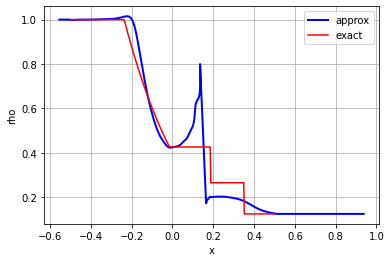

In [11]:
plt.plot(x_all[-1],rho_all[-1],"b",linewidth=2,label = "approx")
plt.xlabel("x")
plt.ylabel("rho")
plt.grid()
plt.plot(values['x'], values['rho'], linewidth=1.5, color='r',label = "exact")
plt.legend()


2 Velocity

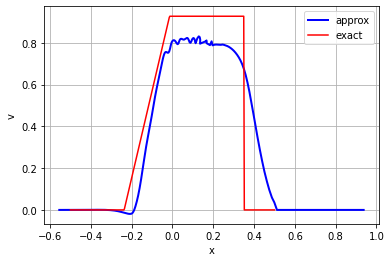

In [12]:
plt.plot(x_all[-1],v_all[-1],"b",linewidth=2,label="approx")
plt.xlabel("x")
plt.ylabel("v")
plt.plot(values['x'], values['u'], linewidth=1.5, color="r", label="exact")
plt.legend()
plt.grid()

3 Pressure

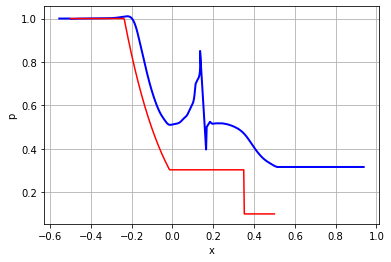

In [13]:
plt.plot(x_all[-1],p_all[-1],"b",linewidth=2,label="approx")
plt.xlabel("x")
plt.ylabel("p")
plt.grid()
plt.plot(values['x'], values['p'], linewidth=1.5, color='r',label="exact")

4 Thermal Energy

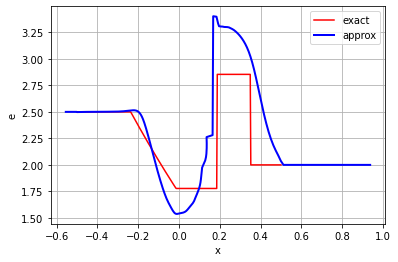

In [14]:
e = values['p'] / (1.4 - 1) / values['rho']
plt.plot(values['x'], e, linewidth=1.5, color='r',label="exact")
plt.plot(x_all[-1],e_all[-1],"b",linewidth=2,label = "approx")
plt.xlabel("x")
plt.ylabel("e")
plt.grid()
plt.legend()